## Análisis predictivo utilizando datos de taxis de la ciudad de Nueva York

En este ejemplo, utilizamos Spark para realizar un análisis predictivo sobre los datos de propinas de los viajes en taxi de Nueva York. Los datos están disponibles a través de Azure Open Datasets. Este subconjunto del conjunto de datos contiene información sobre los viajes en taxis amarillos, incluyendo detalles de cada viaje, como la hora y la ubicación de inicio y finalización, el costo y otros atributos interesantes.

En los siguientes pasos, desarrollaremos un modelo para predecir si un viaje específico incluye una propina o no.

### Importacion de librerias

In [0]:
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from pyspark.sql.functions import unix_timestamp, date_format, col, when
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

### Construcción del DataFrame de entrada

Dado que los datos en bruto están en formato Parquet, puedes utilizar el contexto de Spark para cargar el archivo en memoria como un DataFrame directamente. Aunque el código en los siguientes pasos utiliza las opciones predeterminadas, es posible forzar la asignación de tipos de datos y otros atributos del esquema si es necesario.

Ejecuta las siguientes líneas para crear un DataFrame de Spark pegando el código en una nueva celda. Este paso recupera los datos a través de la API de Open Datasets. Al cargar todos estos datos, se generan aproximadamente 1.500 millones de filas.

In [0]:
from azureml.opendatasets import NycTlcYellow
from dateutil import parser

end_date = parser.parse('2018-06-06')
start_date = parser.parse('2020-05-01')
nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
nyc_tlc

Out[2]: <azureml.opendatasets._nyc_tlc_yellow.NycTlcYellow at 0x7f14c0502d90>

In [0]:
# Define las fechas de inicio y fin
start_date = parser.parse('2018-05-01')
end_date = parser.parse('2018-06-06')

# Carga el conjunto de datos para el rango de fechas especificado
nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)

# Convierte el conjunto de datos a un DataFrame de Pandas
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()


{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from /tmp/tmp3enegy36/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2018/puMonth=5/part-00000-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4-fa74bfbd47bc-426339-118.c000.snappy.parquet
[Info] read from /tmp/tmp3enegy36/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2018/puMonth=5/part-00002-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4-fa74bfbd47bc-426334-119.c000.snappy.parquet
[Info] read from /tmp/tmp3enegy36/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2018/puMonth=5/part-00004-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4-fa74bfbd47bc-426331-116.c000.snappy.parquet
[Info] read from /tmp/tmp3enegy36/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/yellow/puYear=2018/puMonth=5/part-00006-tid-8898858832658823408-a1de80bd-eed3-4d11-b9d4-fa74bfbd47bc-426326-116.c000.s

In [0]:
filtered_df = spark.createDataFrame(nyc_tlc_df)


El inconveniente de un filtrado simple es que, desde una perspectiva estadística, podría introducir sesgos en los datos. Otra estrategia es utilizar el muestreo incorporado en Spark.

El siguiente código reduce el conjunto de datos a aproximadamente 15,000 filas, si se aplica después del código anterior. Puedes emplear este paso de muestreo en lugar del filtrado simple o en combinación con él.

In [0]:
# Muestreo sin reemplazo para obtener un número exacto de filas
sampled_taxi_df = filtered_df.sample(False, 0.001, seed=1234)

# Contar el número de filas en el DataFrame muestreado
num_filas = sampled_taxi_df.count()

# Mostrar el número de filas
print(f"El DataFrame muestreado contiene {num_filas} filas.")


El DataFrame muestreado contiene 10732 filas.


Ahora es posible examinar los datos para verificar lo que se ha leído. Generalmente, es preferible revisar una muestra de los datos en lugar del conjunto completo, dependiendo del tamaño del conjunto de datos.

El siguiente código ofrece dos métodos para visualizar los datos. El primero es básico, mientras que el segundo proporciona una experiencia más completa en forma de cuadrícula, además de la capacidad de visualizar los datos gráficamente.

In [0]:
display(sampled_taxi_df)

vendorID tpepPickupDateTime tpepDropoffDateTime passengerCount tripDistance puLocationId doLocationId startLon startLat endLon endLat rateCodeId storeAndFwdFlag paymentType fareAmount extra mtaTax improvementSurcharge tipAmount tollsAmount totalAmount 2 2018-05-06T15:07:24.000+0000 2018-05-06T15:16:10.000+0000 1 1.6 164 114 null null null null 1 N 1 7.5 0.0 0.5 0.3 1.66 0.0 9.96 2 2018-05-06T15:41:24.000+0000 2018-05-06T15:52:01.000+0000 1 1.28 107 186 null null null null 1 N 2 8.5 0.0 0.5 0.3 0.0 0.0 9.3 2 2018-05-06T19:46:32.000+0000 2018-05-06T20:27:22.000+0000 1 18.19 132 163 null null null null 2 N 1 52.0 0.0 0.5 0.3 0.0 5.76 58.56 2 2018-05-23T13:13:53.000+0000 2018-05-23T13:19:24.000+0000 1 1.52 125 13 null null null null 1 N 2 7.0 0.0 0.5 0.3 0.0 0.0 7.8 1 2018-05-06T13:21:19.000+0000 2018-05-06T13:34:01.000+0000 2 3.6 236 194 null null null null 1 N 1 13.5 0.0 0.5 0.3 1.5 5.76 21.56 2 2018-05-06T18:45:06.000+0000 2018-05-06T19:01:47.000+0000 2 3.0 224 163 null null null null 1 N 1 13.5 0.0 0.5 0.3 2.0 0.0 16.3 1 2018-05-23T05:41:36.000+0000 2018-05-23T05:43:45.000+0000 1 0.7 100 163 null null null null 1 N 2 4.0 0.5 0.5 0.3 0.0 0.0 5.3 2 2018-05-22T23:49:35.000+0000 2018-05-22T23:55:46.000+0000 1 1.0 24 166 null null null null 1 N 2 6.5 0.5 0.5 0.3 0.0 0.0 7.8 1 2018-05-06T20:50:58.000+0000 2018-05-06T21:39:18.000+0000 1 18.4 132 230 null null null null 2 N 1 52.0 0.0 0.5 0.3 8.0 5.76 66.56 1 2018-05-23T04:54:30.000+0000 2018-05-23T05:00:42.000+0000 1 1.3 141 43 null null null null 1 N 1 6.5 0.5 0.5 0.3 1.0 0.0 8.8 2 2018-05-23T11:19:23.000+0000 2018-05-23T11:50:55.000+0000 4 2.48 170 142 null null null null 1 N 1 19.0 0.0 0.5 0.3 5.94 0.0 25.74 2 2018-05-06T18:30:01.000+0000 2018-05-06T18:42:56.000+0000 2 2.81 162 239 null null null null 1 N 2 11.5 0.0 0.5 0.3 0.0 0.0 12.3 1 2018-05-06T12:52:18.000+0000 2018-05-06T13:25:26.000+0000 1 15.0 211 1 null null null null 3 N 1 61.0 0.0 0.0 0.3 15.85 18.0 95.15 2 2018-05-23T06:59:43.000+0000 2018-05-23T07:11:26.000+0000 2 1.42 107 100 null null null null 1 N 1 9.0 0.0 0.5 0.3 2.45 0.0 12.25 2 2018-05-24T00:13:50.000+0000 2018-05-24T00:15:54.000+0000 5 0.3 231 231 null null null null 1 N 1 3.5 0.5 0.5 0.3 1.44 0.0 6.24 1 2018-05-09T20:42:25.000+0000 2018-05-09T20:57:31.000+0000 2 2.4 164 144 null null null null 1 N 1 11.5 0.5 0.5 0.3 2.55 0.0 15.35 1 2018-05-09T17:43:40.000+0000 2018-05-09T17:43:48.000+0000 1 0.0 13 13 null null null null 1 N 3 2.5 1.0 0.5 0.3 0.0 0.0 4.3 2 2018-05-09T19:08:30.000+0000 2018-05-09T19:25:40.000+0000 5 1.86 230 43 null null null null 1 N 2 12.0 1.0 0.5 0.3 0.0 0.0 13.8 2 2018-05-09T18:51:10.000+0000 2018-05-09T19:00:44.000+0000 1 0.95 233 137 null null null null 1 N 1 7.5 1.0 0.5 0.3 2.79 0.0 12.09 1 2018-05-24T10:10:23.000+0000 2018-05-24T10:40:33.000+0000 2 3.7 232 229 null null null null 1 N 1 20.0 0.0 0.5 0.3 4.15 0.0 24.95 2 2018-05-09T14:39:02.000+0000 2018-05-09T14:46:47.000+0000 1 0.92 161 164 null null null null 1 N 2 6.5 0.0 0.5 0.3 0.0 0.0 7.3 1 2018-05-09T12:30:28.000+0000 2018-05-09T12:45:28.000+0000 0 1.7 170 162 null null null null 1 N 2 10.5 0.0 0.5 0.3 0.0 0.0 11.3 2 2018-05-24T06:47:29.000+0000 2018-05-24T06:57:47.000+0000 2 2.04 113 230 null null null null 1 N 1 9.5 0.0 0.5 0.3 1.0 0.0 11.3 1 2018-05-09T14:13:19.000+0000 2018-05-09T14:32:22.000+0000 2 1.7 246 43 null null null null 1 N 1 13.0 0.0 0.5 0.3 2.75 0.0 16.55 2 2018-05-09T19:16:55.000+0000 2018-05-09T19:30:39.000+0000 2 1.51 79 90 null null null null 1 N 1 10.0 1.0 0.5 0.3 2.36 0.0 14.16 2 2018-05-24T11:16:01.000+0000 2018-05-24T11:26:11.000+0000 1 1.7 238 142 null null null null 1 N 1 8.5 0.0 0.5 0.3 1.0 0.0 10.3 2 2018-05-23T22:08:20.000+0000 2018-05-23T22:36:07.000+0000 1 9.52 236 196 null null null null 1 N 2 30.5 0.5 0.5 0.3 0.0 0.0 31.8 2 2018-05-23T22:35:22.000+0000 2018-05-23T22:35:37.000+0000 1 0.14 163 163 null null null null 2 N 1 52.0 0.0 0.5 0.3 10.56 0.0 63.36 2 2018-05-09T19:35:12.000+0000 2018-05-09T19:46:01.000+0000 1 1.59 211 158 null null null null

Dependiendo del tamaño del conjunto de datos generado y tu necesidad de experimentar o ejecutar el notebook varias veces, podrías querer almacenar en caché el conjunto de datos localmente en el espacio de trabajo. Existen tres métodos para realizar el almacenamiento en caché explícito:

- Guardar el DataFrame localmente como archivo
- Guardar el DataFrame como tabla o vista temporal 
- Guardar el DataFrame como tabla permanente

Los dos primeros enfoques se muestran en los siguientes ejemplos de código.

La creación de una tabla o vista temporal proporciona diferentes rutas de acceso a los datos, pero solo dura mientras la sesión de Spark esté activa.

In [0]:
sampled_taxi_df.createOrReplaceTempView("nytaxi")

### Preparación de los datos

Los datos en su forma bruta generalmente no son adecuados para alimentar directamente a un modelo. Es necesario realizar una serie de transformaciones para que el modelo pueda procesarlos correctamente.

El siguiente código realiza cuatro tipos de operaciones:

- Eliminación de valores atípicos o incorrectos mediante filtrado
- Eliminación de columnas innecesarias 
- Creación de nuevas columnas derivadas de los datos originales para mejorar el rendimiento del modelo (featurización)
- Etiquetado: Al realizar clasificación binaria (predicción de propinas), necesitamos convertir el monto de la propina en valores 0 o 1

In [0]:
from pyspark.sql.functions import col, date_format, unix_timestamp, when

# Selección de columnas y creación de nuevas columnas
selected_columns = sampled_taxi_df.select(
    'totalAmount',
    'fareAmount',
    'tipAmount',
    'paymentType',
    'rateCodeId',
    'passengerCount',
    'tripDistance',
    'tpepPickupDateTime',
    'tpepDropoffDateTime',
    date_format('tpepPickupDateTime', 'hh').alias('pickupHour'),
    date_format('tpepPickupDateTime', 'EEEE').alias('weekdayString'),
    (unix_timestamp(col('tpepDropoffDateTime')) - unix_timestamp(col('tpepPickupDateTime'))).alias('tripTimeSecs'),
    (when(col('tipAmount') > 0, 1).otherwise(0)).alias('tipped')
)


In [0]:

# Filtrado de datos
filtered_df = selected_columns.filter(
    (col('passengerCount') > 0) & (col('passengerCount') < 8) &
    (col('tipAmount') >= 0) & (col('tipAmount') <= 25) &
    (col('fareAmount') >= 1) & (col('fareAmount') <= 250) &
    (col('tipAmount') < col('fareAmount')) &
    (col('tripDistance') > 0) & (col('tripDistance') <= 100) &
    (col('rateCodeId') <= 5) &
    (col('paymentType').isin({"1", "2"}))
)

# Asignación final
taxi_df = filtered_df


In [0]:
features_df = taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount'\
                                                , 'tripDistance', 'weekdayString', 'pickupHour','tripTimeSecs','tipped'\
                                                , when((taxi_df.pickupHour <= 6) | (taxi_df.pickupHour >= 20),"Night")\
                                                .when((taxi_df.pickupHour >= 7) & (taxi_df.pickupHour <= 10), "AMRush")\
                                                .when((taxi_df.pickupHour >= 11) & (taxi_df.pickupHour <= 15), "Afternoon")\
                                                .when((taxi_df.pickupHour >= 16) & (taxi_df.pickupHour <= 19), "PMRush")\
                                                .otherwise(0).alias('trafficTimeBins')
                                              )\
                                       .filter((taxi_df.tripTimeSecs >= 30) & (taxi_df.tripTimeSecs <= 7200))

### Crear un modelo de regresión logística 

El paso final es transformar los datos etiquetados a un formato que pueda ser analizado mediante regresión logística. El algoritmo requiere como entrada pares de _etiqueta/vector de características_, donde el vector de características es un conjunto de números que representa el punto de entrada.

Por lo tanto, necesitamos convertir las columnas categóricas a valores numéricos. Específicamente, debemos transformar las columnas `trafficTimeBins` y `weekdayString` a representaciones enteras. Existen varios métodos para realizar esta conversión. El siguiente ejemplo utiliza el enfoque `OneHotEncoder`, que es uno de los más comunes.

In [0]:
# Como el algoritmo solo funciona con características numéricas, convertimos las variables para que puedan ser utilizadas
sI1 = StringIndexer(inputCol="trafficTimeBins", outputCol="trafficTimeBinsIndex")
en1 = OneHotEncoder(dropLast=False, inputCol="trafficTimeBinsIndex", outputCol="trafficTimeBinsVec")  
sI2 = StringIndexer(inputCol="weekdayString", outputCol="weekdayIndex")
en2 = OneHotEncoder(dropLast=False, inputCol="weekdayIndex", outputCol="weekdayVec")

# Crear un nuevo DataFrame con las codificaciones aplicadas
encoded_df = Pipeline(stages=[sI1, en1, sI2, en2]).fit(features_df).transform(features_df)

> Esta acción genera un nuevo DataFrame con todas las columnas en el formato correcto para entrenar el modelo.

### Entrenar un modelo de regresión logística

El primer paso es dividir el conjunto de datos en un conjunto de entrenamiento y otro de prueba/validación. La división aquí es arbitraria. Puedes experimentar con diferentes proporciones para ver cómo afectan al rendimiento del modelo.

In [0]:
# Definir la proporción entre datos de entrenamiento y prueba 
train_ratio = 0.7
test_ratio = (1-train_ratio) 
seed = 1234

# Dividir el DataFrame en conjuntos de entrenamiento y prueba
train_data_df, test_data_df = encoded_df.randomSplit([train_ratio, test_ratio], seed=seed)

Ahora que tenemos dos DataFrames, el siguiente paso es crear la fórmula del modelo y ejecutarla contra el DataFrame de entrenamiento. Después podremos validarla usando el DataFrame de pruebas. Es recomendable experimentar con diferentes versiones de la fórmula del modelo para ver el impacto de diferentes combinaciones.

In [0]:
train_data_df

Out[19]: DataFrame[totalAmount: double, fareAmount: double, tipAmount: double, paymentType: string, passengerCount: int, tripDistance: double, weekdayString: string, pickupHour: string, tripTimeSecs: bigint, tipped: int, trafficTimeBins: string, traffic_time_index: double, traffic_time_vec: vector, weekday_index: double, weekday_vec: vector]

In [0]:
## Crear nuevo objeto de regresión logística para el modelo
logReg = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'tipped')

## Fórmula del modelo
classFormula = RFormula(formula="tipped ~ pickupHour + weekdayVec + passengerCount + tripTimeSecs + tripDistance + fareAmount + paymentType")

## Realizar entrenamiento y crear modelo de regresión logística
lr_model = Pipeline(stages=[classFormula, logReg]).fit(train_data_df)

## Guardar modelo (opcional) como caché entre sesiones  
datestamp = datetime.now().strftime('%m-%d-%Y-%s')
file_name = "lr_model_" + datestamp 
model_path = file_name
lr_model.save(model_path)

## Obtener predicciones en datos de prueba y evaluar ROC
predictions = lr_model.transform(test_data_df)
prediction_labels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(prediction_labels)
print("Area bajo ROC = %s" % metrics.areaUnderROC)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area bajo ROC = 0.9748837209302326


### Evaluación  

Ahora podemos construir una visualización final para ayudarnos a interpretar los resultados de esta prueba. Una [curva ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) es una forma eficaz de revisar el resultado.

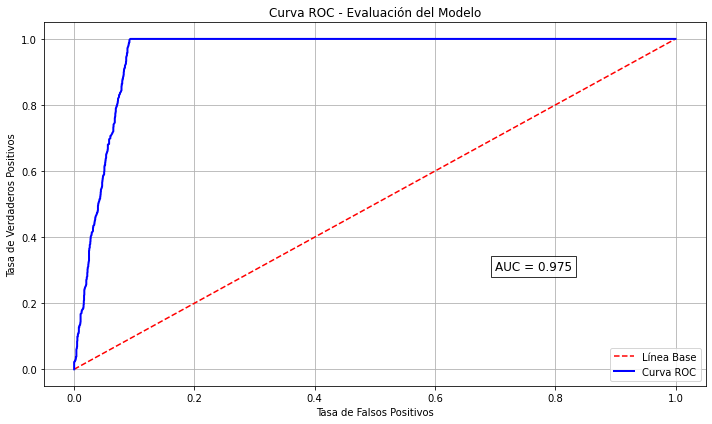

In [0]:
## Graficar la curva ROC usando el objeto modelSummary directamente
modelSummary = lr_model.stages[-1].summary

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'r--', label='Línea Base')
plt.plot(modelSummary.roc.select('FPR').collect(),
        modelSummary.roc.select('TPR').collect(),
        'b-', linewidth=2, label='Curva ROC')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Evaluación del Modelo')
plt.legend()
plt.grid(True)

# Añadir texto del área bajo la curva ROC
auc = metrics.areaUnderROC
plt.text(0.7, 0.3, f'AUC = {auc:.3f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()